# Predicting a Biological Response
Задача на kaggle: https://www.kaggle.com/c/bioresponse

Данные: https://www.kaggle.com/c/bioresponse/data

По данным характеристикам молекулы требуется определить, будет ли дан биологический ответ (biological response). Признаки нормализаваны.

## xgboost.XGBClassifier
### Предобработка данных

In [1]:
from sklearn import ensemble, model_selection, metrics 
import numpy as np
import pandas as pd
import xgboost as xgb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
bioresponce = pd.read_csv('biological_response.csv')

In [3]:
bioresponce.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
bioresponce_target = bioresponce.Activity.values
bioresponce_data = bioresponce.iloc[:, 1:]

### Модель sklearn.ensemble.RandomForestClassifier
#### Зависимость качества от количесвта деревьев

In [5]:
n_trees=[1]+list(range(10,55,5))

In [6]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
    score = model_selection.cross_val_score(estimator, bioresponce_data, bioresponce_target, 
                                             scoring = 'accuracy', cv = 3)    
    scoring.append(score)


Wall time: 17 s


In [7]:
scoring = np.asmatrix(scoring)
scoring

matrix([[0.66906475, 0.668     , 0.6704    ],
        [0.75859313, 0.7592    , 0.7504    ],
        [0.78097522, 0.7616    , 0.7592    ],
        [0.78417266, 0.7736    , 0.7648    ],
        [0.78257394, 0.7736    , 0.7704    ],
        [0.78816946, 0.7752    , 0.7736    ],
        [0.78816946, 0.7856    , 0.7776    ],
        [0.78896882, 0.78      , 0.7832    ],
        [0.78976819, 0.7856    , 0.7896    ],
        [0.79536371, 0.7816    , 0.7928    ]])

Получили матрицу. Эта матрица состоит из 10 строк. Каждая строка соответствует количеству деревьев, над которыми строили случайный лес. Получается, что первая строка соответствует одному дереву, последняя строка соответствует 50 деревьям. Внутри мы видим в каждой строке три значения качества. Так как делали кросс-валидацию по трем фолдам, соответственно, каждое значение соответствует качеству на одном фолде.

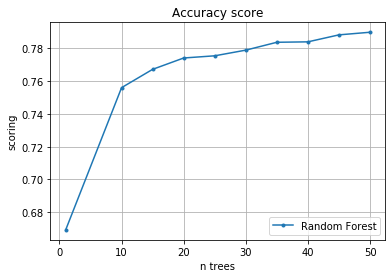

In [8]:
pylab.plot(n_trees, scoring.mean(axis=1), marker='.', label="Random Forest")
pylab.grid(True)
pylab.xlabel('n trees')
pylab.ylabel('scoring')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

При использовании одного дерева качество модели будет очень низким, и при увеличении количества деревьев качество начинает расти.

### Модель xgboost.XGBClassifier
#### Кривые обучения для деревьев большей глубины

In [9]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = model_selection.cross_val_score(estimator, bioresponce_data, bioresponce_target, 
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)

Wall time: 1min 54s


In [10]:
xgb_scoring = np.asmatrix(xgb_scoring)
xgb_scoring

matrix([[0.76498801, 0.756     , 0.756     ],
        [0.77617906, 0.7752    , 0.7688    ],
        [0.77857714, 0.7744    , 0.7768    ],
        [0.7873701 , 0.7784    , 0.7768    ],
        [0.79216627, 0.7736    , 0.7832    ],
        [0.79776179, 0.7776    , 0.7824    ],
        [0.79616307, 0.7816    , 0.78      ],
        [0.79296563, 0.7848    , 0.7792    ],
        [0.79856115, 0.7832    , 0.7808    ],
        [0.79936051, 0.7832    , 0.7832    ]])

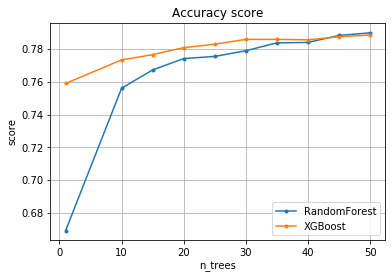

In [11]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

Как видно по результатам, XGBClassifier работает гораздно медленее, чем Random Forest
Полученная матрица - практически такая же.
Оба алгоритма имеют довольно высокое качество. Это видно из правой части графика. Однако, для того чтобы достигнуть его, градиентному бустингу нужно существенно меньше деревьев, чем случайному лесу. В левой части графика видно, что градиентный бустинг начинает с более высокой отметки.